In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

### Spergel scarlet fitting errors

In [6]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')[0:5000]

# Modeling using spergel profile
method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
]
meas_cat = vstack([Table.read(file) for file in files])
params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits')[0:5000]

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
print('Incomplete files:', np.sum(bad_flag))
print('Failed modelings:', np.isnan(meas_cat['rhalf_circularized']).sum())
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])
print('Surface brightness cut:', np.sum(~(params_cat['SB_eff_g'] > 28)))
bad_flag |= (params_cat['SB_eff_g'] > 28)
print('Spergel size cut:', np.sum(~(meas_cat['rhalf_spergel'] * 0.168 < 1.5)))
bad_flag |= (meas_cat['rhalf_spergel'] * 0.168 < 1.5)

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]

print('Number of survived objs afterall:', len(obj_cat))

meas_cat['rhalf_spergel'] = 0.168 * meas_cat['rhalf_spergel']
meas_cat['rhalf_circularized'] = 0.168 * meas_cat['rhalf_circularized']
meas_cat['sersic_rhalf'] = 0.168 * meas_cat['sersic_rhalf']


Total number of objects: 5000
Incomplete files: 81
Failed modelings: 0
Surface brightness cut: 4438
Spergel size cut: 4887
Number of survived objs afterall: 4356


In [7]:
re_meas = meas_cat['rhalf_spergel'].data
re_truth =  params_cat['rhalf_circularized'].data

spergel_nu = meas_cat['spergel_nu'].data

print(np.mean(re_meas - re_truth), np.std(re_meas - re_truth))

ell_truth = params_cat['ellip'].data
ell_meas = meas_cat['ell_sym'].data

# SB
SB_meas = {}
SB_truth = {}
SB_meas['g'] = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth['g'] = params_cat['SB_eff_g'].data
SB_meas['r'] = meas_cat['SB_eff_avg'].data[:, 1]
SB_truth['r'] = SB_truth['g'] - params_cat['g-r'].data
SB_meas['i'] = meas_cat['SB_eff_avg'].data[:, 2]
SB_truth['i'] = SB_truth['g'] - params_cat['g-i'].data

# Color
gi_truth = params_cat['g-i'].data
gi_meas = (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]).data
gr_truth = params_cat['g-r'].data
gr_meas = (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]).data
ri_truth = params_cat['g-i'].data - params_cat['g-r'].data
ri_meas = (meas_cat['mag'][:, 1] - meas_cat['mag'][:, 2]).data

# Mag
mag_meas = {}
mag_truth = {}
mag_meas['g'] = meas_cat['mag'][:, 0].data
mag_meas['r'] = meas_cat['mag'][:, 1].data
mag_meas['i'] = meas_cat['mag'][:, 2].data
mag_truth['g'] = params_cat['mag_g'].data
mag_truth['r'] = mag_meas['g'] - params_cat['g-r'].data
mag_truth['i'] = mag_meas['g'] - params_cat['g-i'].data

-0.5814230702016114 1.2213493152596788


### Three methods
1. Train a nueral net to predict truth for each mock galaxy.
    For this method, bias correction works very well, but it will be hard to derive std using this method. Std requires binning anyway. 
    
2. Bin the parameter space, calculate `delta = (meas - truth)`, then fit a polynomial for delta as a function of parameters.
    This would work fine?
    
3. same as 2, but replace the polynomial with a neural net.  

### Method 3

In [8]:
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')
# from sample_cuts import bin_data, quant_error, get_edge_cens, bin_data_moving_window
from scipy.stats import binned_statistic_dd
from sample_cuts import quant_measurement
import joblib

In [9]:
import matplotlib.colors as colors

In [10]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

Score: 0.954634927707042
Score: 0.8420862817126729


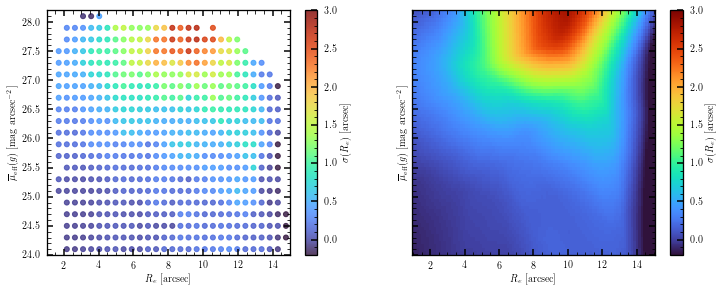

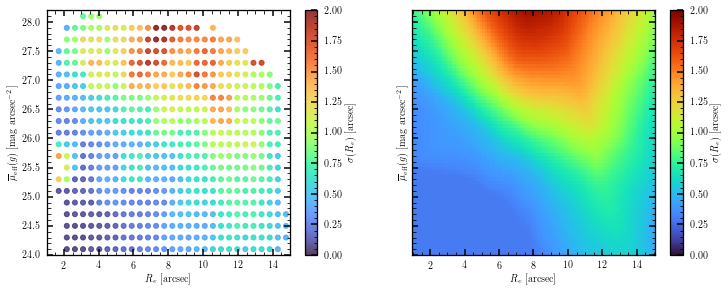

In [11]:
re_bias = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    re_truth - re_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=-0.2, vmax=3
)

re_std = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    re_truth - re_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=0.3,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=2, cbar_label=r'$\sigma(R_e)$ [arcsec]',
)

(2.0, 15.0)

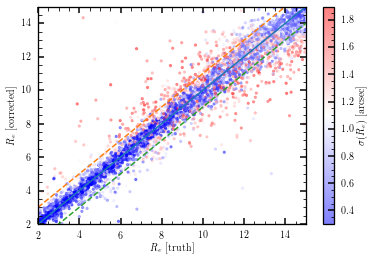

In [12]:
re_meas_corr = re_meas + re_bias.predict(np.vstack([re_meas, SB_meas['g']]).T)
re_meas_std = re_std.predict(np.vstack([re_meas, SB_meas['g']]).T)
re_meas_std[re_meas_std < 0.3] = 0.3

plt.scatter(re_truth, re_meas_corr, 
            c=re_meas_std, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(label=r'$\sigma(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [corrected]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [13]:
joblib.dump(re_bias, './Catalog/mock_sample/spergel/bias_std/re_bias.pkl')
joblib.dump(re_std, './Catalog/mock_sample/spergel/bias_std/re_std.pkl')

['./Catalog/mock_sample/spergel/bias_std/re_std.pkl']

#### Magnitudes

In [14]:
filt = 'g'

Score: 0.9037491226051816
Score: 0.9216321543972251


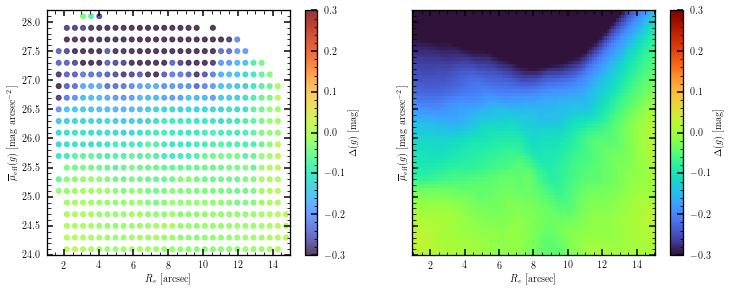

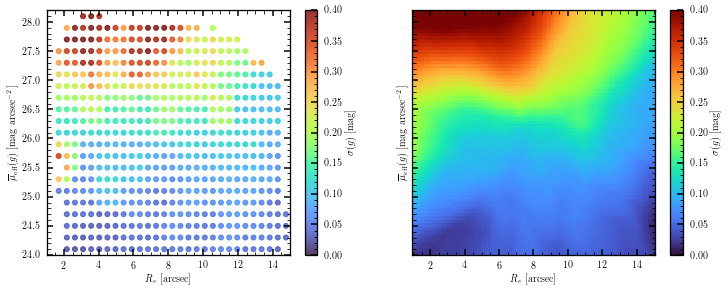

In [15]:
mag_bias = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    mag_truth[filt] - mag_meas[filt],
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=-0.3, vmax=0.3, cbar_label=f'$\Delta({filt})$ [mag]',
)

mag_std = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    mag_truth[filt] - mag_meas[filt],
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.4, cbar_label=f'$\sigma({filt})$ [mag]',
)

(16.0, 25.0)

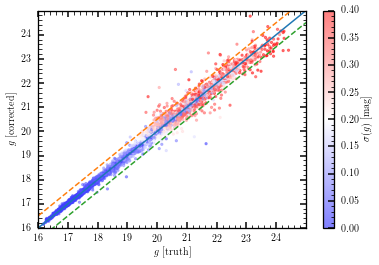

In [16]:
mag_meas_corr = mag_meas[filt] + mag_bias.predict(np.vstack([re_meas, SB_meas['g']]).T)
mag_meas_std = mag_std.predict(np.vstack([re_meas, SB_meas['g']]).T)
mag_meas_std[mag_meas_std < 0.05] = 0.05

plt.scatter(mag_truth[filt], mag_meas_corr, 
            c=mag_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.4,
            s=5, alpha=0.5)
x = np.linspace(16, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')

plt.xticks(ticks=np.arange(16, 25, 1))
plt.yticks(ticks=np.arange(16, 25, 1))
plt.colorbar(label=f'$\sigma({filt})$ [mag]')
plt.xlabel(f'${filt}$ [truth]')
plt.ylabel(f'${filt}$ [corrected]')
plt.xlim(16, 25)
plt.ylim(16, 25)

In [17]:
joblib.dump(mag_bias, f'./Catalog/mock_sample/spergel/bias_std/mag_{filt}_bias.pkl')
joblib.dump(mag_std, f'./Catalog/mock_sample/spergel/bias_std/mag_{filt}_std.pkl')

['./Catalog/mock_sample/spergel/bias_std/mag_g_std.pkl']

#### Surface brightness

We derive the correction for SB based on the corrections for R_e and mag

In [40]:
from sklearn.pipeline import make_pipeline

In [59]:
_range=[[1, 15], [23, 29]]

In [60]:
x1_test, x2_test = np.meshgrid(np.linspace(*_range[0], 100),
                               np.linspace(*_range[1], 100))

In [61]:
mag_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)

array([ 0.00331867,  0.00301469,  0.00268161, ..., -0.37237851,
       -0.35674608, -0.34135876])

In [45]:
re_bias.predict(np.vstack([re_meas, SB_meas['g']]).T,)

array([0.2383917 , 1.62956192, 0.61770648, ..., 0.30270642, 0.21525447,
       0.53941477])

In [62]:
A = 5 * re_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T) / x1_test.ravel() / np.log(10)

In [63]:
B = mag_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)

In [56]:
B+A

array([ 0.01931098,  0.08027675,  0.0925246 , ...,  0.00672086,
       -0.01476485, -0.00611053])

In [64]:
SB_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)

array([-0.0833393 , -0.08005492, -0.0768096 , ...,  0.020379  ,
        0.01660933,  0.01281921])

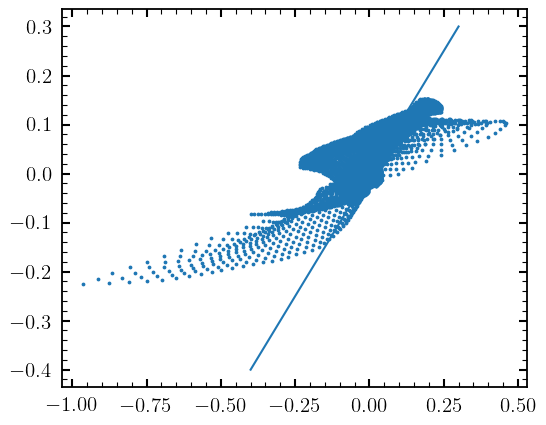

In [67]:
plt.scatter(B+A,
            SB_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T), s=3)
x = np.linspace(-0.4, 0.3)
plt.plot(x, x)

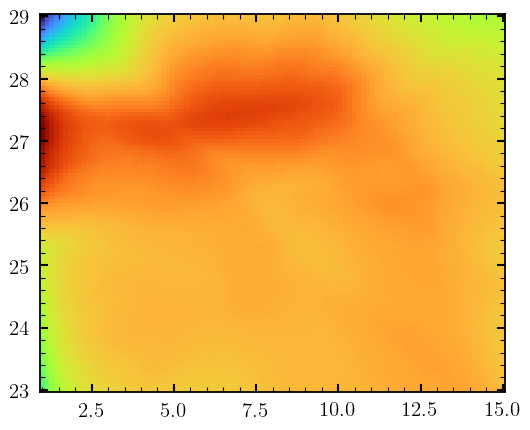

In [68]:
plt.pcolormesh(x1_test, x2_test, (B+A).reshape(
                *x1_test.shape), alpha=1)

In [36]:
A = mag_std.predict(np.vstack([re_meas, SB_meas['g']]).T,)
B = 5 * re_std.predict(np.vstack([re_meas, SB_meas['g']]).T,) / re_meas

In [39]:
re_std.predict(np.vstack([re_meas, SB_meas['g']]).T,) / re_meas

array([0.08264773, 0.1438268 , 0.15721176, ..., 0.06591038, 0.06133129,
       0.31066481])

In [37]:
np.sqrt(A**2 + B**2)

array([0.42524692, 0.75203475, 0.8057538 , ..., 0.33862992, 0.31826697,
       1.5997847 ])

In [38]:
SB_std.predict(np.vstack([re_meas, SB_meas['g']]).T,) / re_meas

array([0.01588777, 0.01254411, 0.02699314, ..., 0.00543475, 0.00821698,
       0.06132682])

#### Surface brightness

In [33]:
filt = 'i'

Score: 0.8500792258966077
Score: 0.6223394836095651


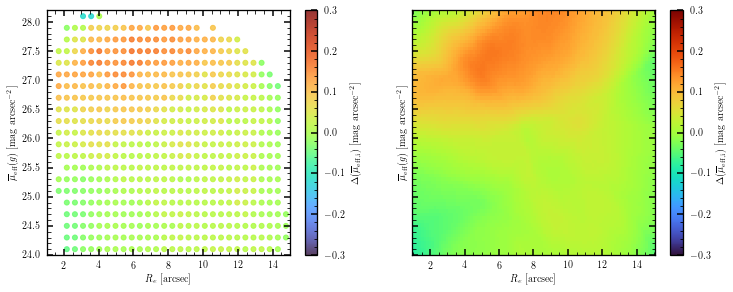

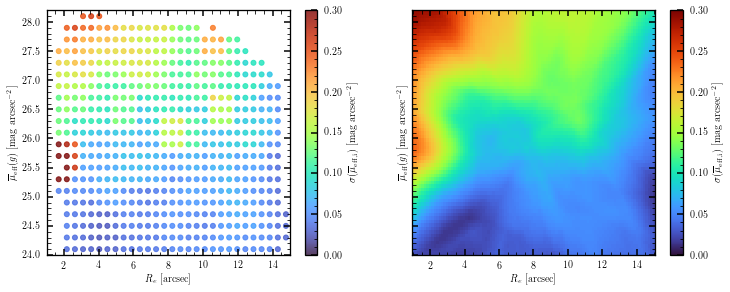

In [34]:
SB_bias = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    SB_truth[filt] - SB_meas[filt],
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=-0.3, vmax=0.3, 
    cbar_label=r'$\Delta(\overline{\mu}_{\rm eff, ' + filt + '})$ [mag arcsec$^{-2}$]',
)

SB_std = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    SB_truth[filt] - SB_meas[filt],
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.3, 
    cbar_label=r'$\sigma(\overline{\mu}_{\rm eff, ' + filt + '})$ [mag arcsec$^{-2}$]',
)

(23.0, 29.0)

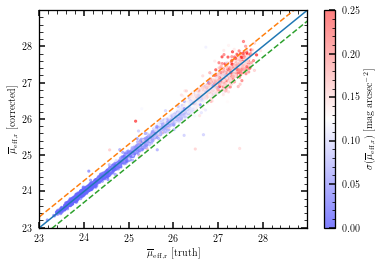

In [31]:
SB_meas_corr = SB_meas[filt] + SB_bias.predict(np.vstack([re_meas, SB_meas['g']]).T)
SB_meas_std = SB_std.predict(np.vstack([re_meas, SB_meas['g']]).T)
SB_meas_std[SB_meas_std < 0.05] = 0.05

plt.scatter(SB_truth[filt], SB_meas_corr, 
            c=SB_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.25,
            s=5, alpha=0.5)
x = np.linspace(23, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.xticks(ticks=np.arange(23, 29, 1))
plt.yticks(ticks=np.arange(23, 29, 1))
plt.colorbar(label=r'$\sigma(\overline{\mu}_{\rm eff, ' + filt + '})$ [mag arcsec$^{-2}$]')
plt.xlabel(r'$\overline{\mu}_{\rm eff, ' + filt + '}$ [truth]')
plt.ylabel(r'$\overline{\mu}_{\rm eff, ' + filt + '}$ [corrected]')
plt.xlim(23, 29)
plt.ylim(23, 29)

In [21]:
SB_meas_corr = SB_meas[filt] + B+A
SB_meas_std = SB_std.predict(np.vstack([re_meas, SB_meas['g']]).T)
SB_meas_std[SB_meas_std < 0.05] = 0.05

plt.scatter(SB_truth[filt], SB_meas_corr, 
            c=SB_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.25,
            s=5, alpha=0.5)
x = np.linspace(23, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.xticks(ticks=np.arange(23, 29, 1))
plt.yticks(ticks=np.arange(23, 29, 1))
plt.colorbar(label=r'$\sigma(\overline{\mu}_{\rm eff, ' + filt + '})$ [mag arcsec$^{-2}$]')
plt.xlabel(r'$\overline{\mu}_{\rm eff, ' + filt + '}$ [truth]')
plt.ylabel(r'$\overline{\mu}_{\rm eff, ' + filt + '}$ [corrected]')
plt.xlim(23, 29)
plt.ylim(23, 29)

NameError: name 'B' is not defined

In [35]:
joblib.dump(SB_bias, f'./Catalog/mock_sample/spergel/bias_std/SB_eff_{filt}_bias.pkl')
joblib.dump(SB_std, f'./Catalog/mock_sample/spergel/bias_std/SB_eff_{filt}_std.pkl')

['./Catalog/mock_sample/spergel/bias_std/SB_eff_i_std.pkl']

#### Color

Score: 0.31146238252106295
Score: 0.8577645797062705


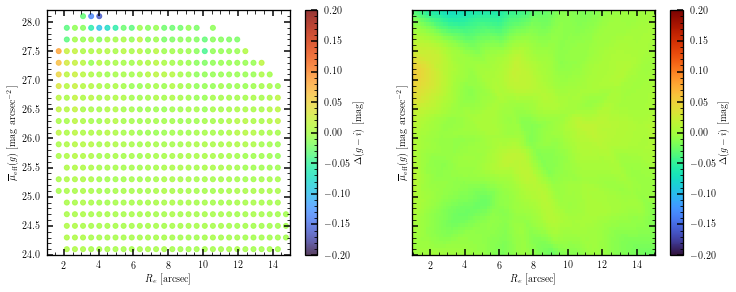

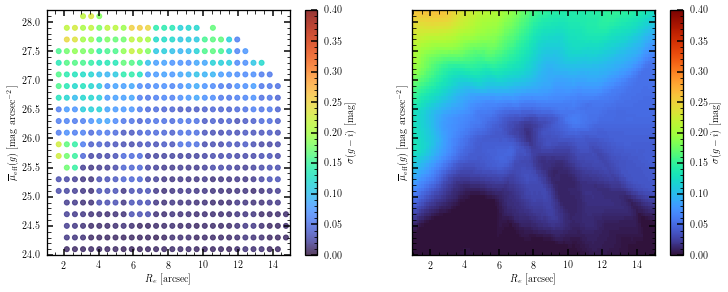

In [23]:
gi_bias = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gi_truth - gi_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=-0.2, vmax=0.2, cbar_label=r'$\Delta(g-i)$ [mag]',
)

gi_std = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gi_truth - gi_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.4, cbar_label=r'$\sigma(g-i)$ [mag]',
)

(-0.3, 1.4)

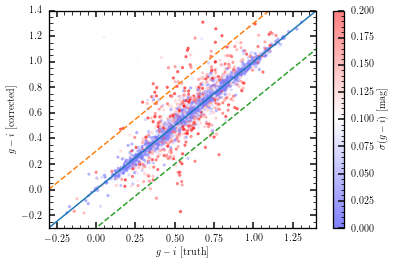

In [24]:
gi_meas_corr = gi_meas + gi_bias.predict(np.vstack([re_meas, SB_meas['g']]).T)
gi_meas_std = gi_std.predict(np.vstack([re_meas, SB_meas['g']]).T)
gi_meas_std[gi_meas_std < 0.05] = 0.05

plt.scatter(gi_truth, gi_meas_corr, 
            c=gi_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.2,
            s=5, alpha=0.5)
x = np.linspace(-0.3, 1.4, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

# plt.xticks(ticks=np.arange(16, 25, 1))
# plt.yticks(ticks=np.arange(16, 25, 1))
plt.colorbar(label=r'$\sigma(g-i)$ [mag]')
plt.xlabel(r'$g-i$ [truth]')
plt.ylabel(r'$g-i$ [corrected]')
plt.xlim(-0.3, 1.4)
plt.ylim(-0.3, 1.4)

In [25]:
joblib.dump(gi_bias, './Catalog/mock_sample/spergel/bias_std/gi_bias.pkl')
joblib.dump(gi_std, './Catalog/mock_sample/spergel/bias_std/gi_std.pkl')

['./Catalog/mock_sample/spergel/bias_std/gi_std.pkl']

Score: 0.3544851880673823
Score: 0.8750311276194279


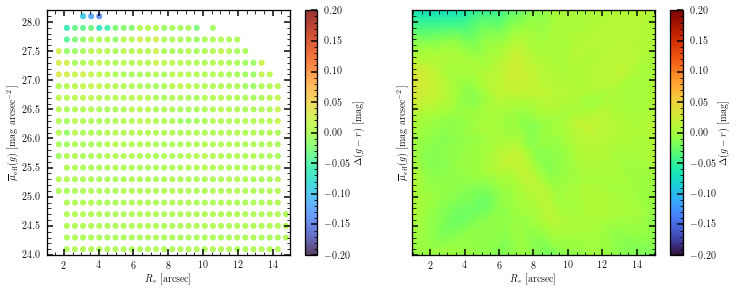

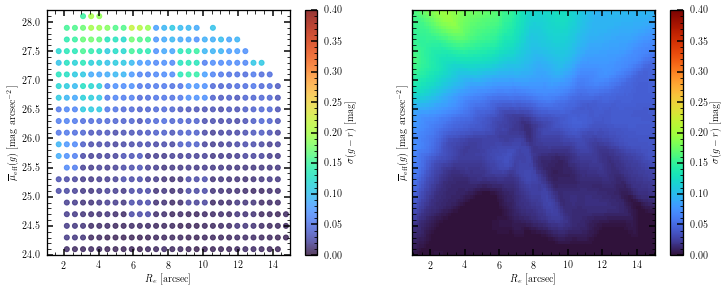

In [26]:
gr_bias = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gr_truth - gr_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=-0.2, vmax=0.2, cbar_label=r'$\Delta(g-r)$ [mag]',
)

gr_std = quant_measurement(
    np.vstack([re_meas, SB_meas['g']]).T,
    gr_truth - gr_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.4, cbar_label=r'$\sigma(g-r)$ [mag]',
)

(-0.3, 1.4)

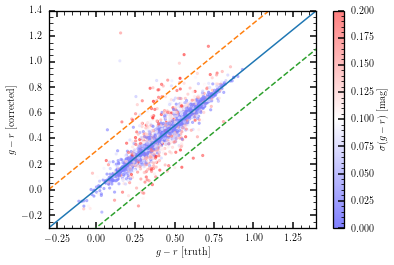

In [27]:
gr_meas_corr = gr_meas + gr_bias.predict(np.vstack([re_meas, SB_meas['g']]).T)
gr_meas_std = gr_std.predict(np.vstack([re_meas, SB_meas['g']]).T)
gr_meas_std[gr_meas_std < 0.05] = 0.05

plt.scatter(gr_truth, gr_meas_corr, 
            c=gr_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.2,
            s=5, alpha=0.5)
x = np.linspace(-0.3, 1.4, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

# plt.xticks(ticks=np.arange(16, 25, 1))
# plt.yticks(ticks=np.arange(16, 25, 1))
plt.colorbar(label=r'$\sigma(g-r)$ [mag]')
plt.xlabel(r'$g-r$ [truth]')
plt.ylabel(r'$g-r$ [corrected]')
plt.xlim(-0.3, 1.4)
plt.ylim(-0.3, 1.4)

In [28]:
joblib.dump(gr_bias, './Catalog/mock_sample/spergel/bias_std/gr_bias.pkl')
joblib.dump(gr_std, './Catalog/mock_sample/spergel/bias_std/gr_std.pkl')

['./Catalog/mock_sample/spergel/bias_std/gr_std.pkl']

---

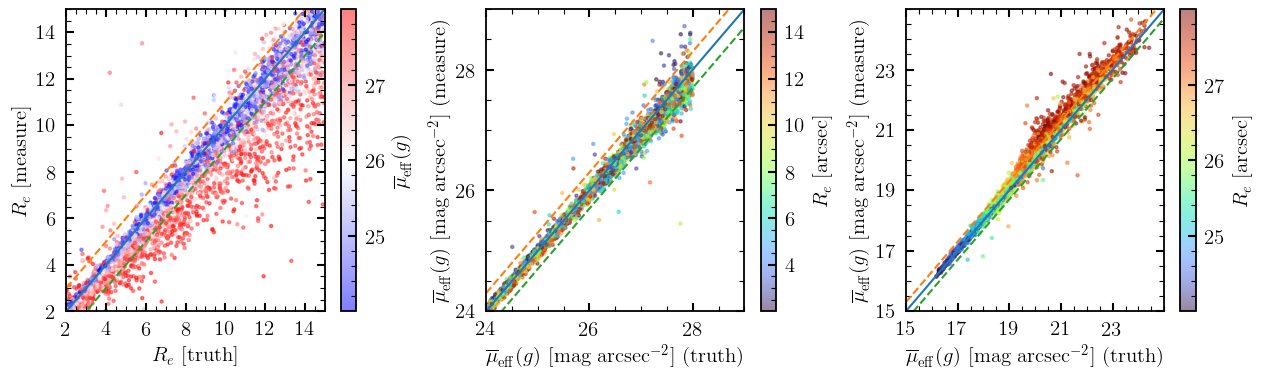

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth['g'], 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$')
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

# compare SB_eff
plt.sca(axes[1])

plt.scatter(SB_truth['g'], SB_meas['g'], c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])

plt.scatter(mag_truth['g'], mag_meas['g'], c=SB_truth['g'], s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.3)

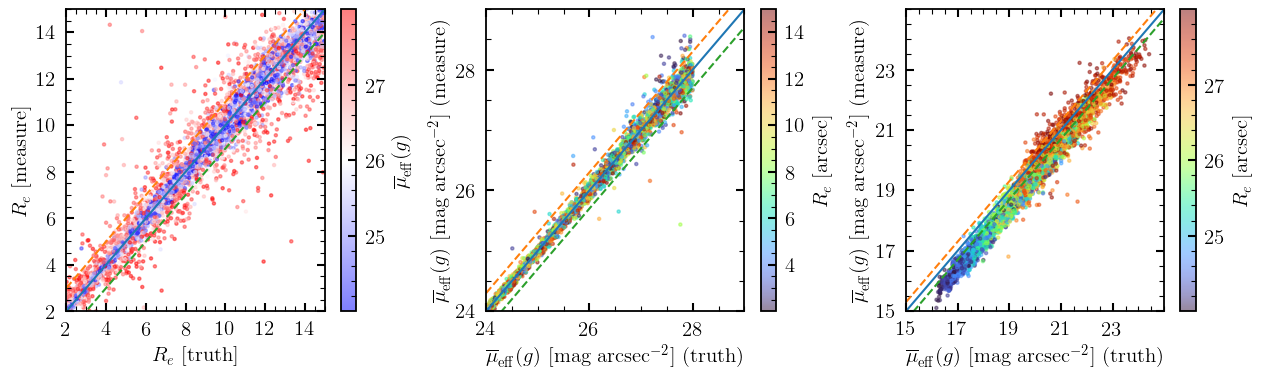

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas_corr, c=SB_truth['g'], 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$')
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

# compare SB_eff
plt.sca(axes[1])

plt.scatter(SB_truth['g'], SB_meas_corr, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])

plt.scatter(mag_truth['g'], mag_meas_corr, c=SB_truth['g'], s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.3)

## Make one good figure

In [49]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

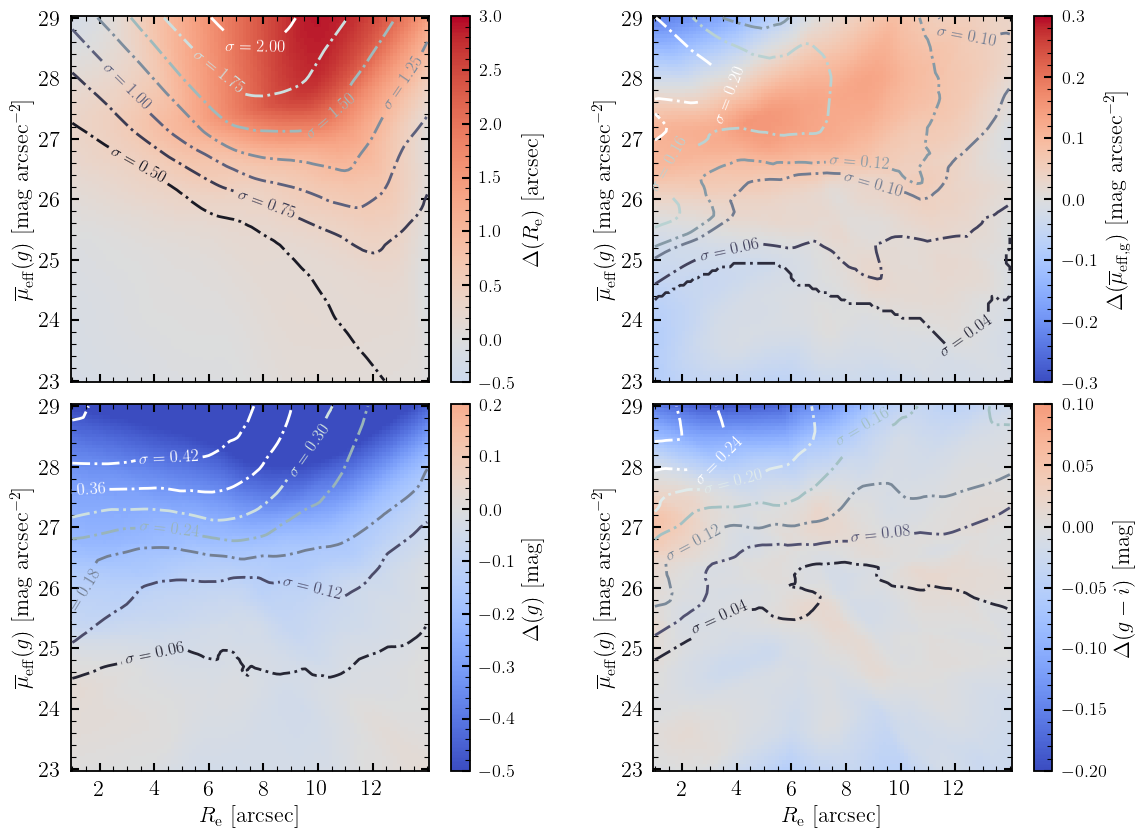

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(13.3, 10), sharey=False, sharex=True)

x1_test, x2_test = np.meshgrid(np.linspace(1, 14, 100),
                               np.linspace(23, 29, 100))
###
plt.sca(axes[0, 0])
ax = plt.gca()
filt = 'g'
re_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_bias.pkl')
re_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_std.pkl')

C_bias = re_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = re_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.3] = 0.3
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.4, vmax=3, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(R_{\rm e})$ [arcsec]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
            cmap='bone', vmin=0.3, vmax=2, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xticks(np.arange(2, 14, 2))

###
plt.sca(axes[0, 1])
ax = plt.gca()
filt = 'g'
SB_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB_eff_{filt}_bias.pkl')
SB_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB_eff_{filt}_std.pkl')

C_bias = SB_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = SB_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.04] = 0.04
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.3, vmax=0.3, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(\overline{\mu}_{\rm eff, g})$ [mag arcsec$^{-2}$]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 levels=[0.04, 0.06, 0.10, 0.12, 0.16, 0.20],
                 cmap='bone', vmin=0., vmax=0.2, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

###
plt.sca(axes[1, 0])
ax = plt.gca()
filt = 'g'
mag_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/mag_{filt}_bias.pkl')
mag_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/mag_{filt}_std.pkl')

C_bias = mag_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = mag_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.05] = 0.05
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.5, vmax=0.2, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(g)$ [mag]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 cmap='bone', vmin=0., vmax=0.35, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.xlabel(r'$R_{\rm e}$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

###
plt.sca(axes[1, 1])
ax = plt.gca()
C_bias = gi_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = gi_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.02] = 0.02
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.2, vmax=0.1, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(g-i)$ [mag]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 cmap='bone', vmin=0., vmax=0.22, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.xlabel(r'$R_{\rm e}$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

plt.subplots_adjust(wspace=0.3, hspace=0.06)

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/meas_error_spergel.pdf', 
#             dpi=30, bbox_inches='tight')